# Catboost Model
- Load each training dataset (water quality, terraclimate, landsat) + merge into 1 training table
- Train CatBoost (and allow fine-tuning)
- Print results (R² and RMSE for Train/Test)
- Validate using validation datasets (load + merge + predict)
- Visualize training to diagnose overfitting / underfitting (learning curves)
- Fill submission_template.csv and export your submission CSV

# (1) Loading Each Training Sets
- What this does:
- Reads the 3 training CSVs

- Normalizes key columns (Latitude/Longitude/Sample Date)
- Merges them into one training dataframe train_df

In [18]:
import pandas as pd
import numpy as np


BASE_DIR = ""  
WQ_TRAIN_PATH   = BASE_DIR + "water_quality_training_dataset.csv"
TC_TRAIN_PATH   = BASE_DIR + "terraclimate_features_training.csv"
LS_TRAIN_PATH   = BASE_DIR + "landsat_features_training.csv"

def _standardize_cols(df: pd.DataFrame) -> pd.DataFrame:
    """Make column names consistent across files."""
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    rename_map = {
        "lat": "Latitude",
        "latitude": "Latitude",
        "lon": "Longitude",
        "long": "Longitude",
        "longitude": "Longitude",
        "sampledate": "Sample Date",
        "sample_date": "Sample Date",
        "date": "Sample Date",
    }
    lower_to_real = {c.lower().replace(" ", "").replace("_", ""): c for c in df.columns}

    for k, v in rename_map.items():
        if k in lower_to_real:
            df = df.rename(columns={lower_to_real[k]: v})

    return df

def _prepare_keys(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure merge keys exist and are clean."""
    df = _standardize_cols(df)

    # Parse date safely
    if "Sample Date" in df.columns:
        df["Sample Date"] = pd.to_datetime(df["Sample Date"], errors="coerce", dayfirst=True)

    # Round lat/lon slightly to reduce float mismatch across sources
    if "Latitude" in df.columns:
        df["Latitude"] = pd.to_numeric(df["Latitude"], errors="coerce").round(6)
    if "Longitude" in df.columns:
        df["Longitude"] = pd.to_numeric(df["Longitude"], errors="coerce").round(6)

    return df

wq_train = _prepare_keys(pd.read_csv(WQ_TRAIN_PATH))
tc_train = _prepare_keys(pd.read_csv(TC_TRAIN_PATH))
ls_train = _prepare_keys(pd.read_csv(LS_TRAIN_PATH))

print("Water quality train:", wq_train.shape)
print("Terraclimate train:", tc_train.shape)
print("Landsat train     :", ls_train.shape)

merge_keys = ["Latitude", "Longitude", "Sample Date"]

for name, df_ in [("wq_train", wq_train), ("tc_train", tc_train), ("ls_train", ls_train)]:
    missing = [k for k in merge_keys if k not in df_.columns]
    if missing:
        raise ValueError(f"{name} is missing merge keys: {missing}. Check your CSV columns.")

train_df = wq_train.merge(tc_train, on=merge_keys, how="left", suffixes=("", "_tc"))
train_df = train_df.merge(ls_train, on=merge_keys, how="left", suffixes=("", "_ls"))

print("\nMerged training shape:", train_df.shape)
print("Columns preview:", train_df.columns[:20].tolist())


Water quality train: (9319, 6)
Terraclimate train: (9319, 4)
Landsat train     : (9319, 9)

Merged training shape: (9319, 13)
Columns preview: ['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus', 'pet', 'nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI']


# Train CatBoost (and allow fine-tuning)

- What this does:
- Defines features + targets
- Splits train/test (for evaluation only)
- Trains CatBoost with early stopping
- Includes a simple tuning hook (you can adjust params easily)

In [19]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

targets = [
    "Total Alkalinity",
    "Electrical Conductance",
    "Dissolved Reactive Phosphorus"
]

features = ['nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI', 'pet']
cat_features = []

missing_f = [f for f in features if f not in train_df.columns]
missing_t = [t for t in targets if t not in train_df.columns]
if missing_f:
    raise ValueError(f"Missing feature columns in train_df: {missing_f}")
if missing_t:
    raise ValueError(f"Missing target columns in train_df: {missing_t}")

clean_df = train_df.dropna(subset=targets).copy()

base_params = dict(
    loss_function="RMSE",
    iterations=5000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=3.0,
    random_strength=1.0,
    eval_metric="RMSE",
    od_type="Iter",
    od_wait=200,
    verbose=200
)

models = {}
train_eval_cache = {}

train_idx, test_idx = train_test_split(clean_df.index, test_size=0.2, random_state=42)

for tgt in targets:
    train_pool = Pool(
        clean_df.loc[train_idx, features],
        label=clean_df.loc[train_idx, tgt],
        cat_features=cat_features
    )
    test_pool = Pool(
        clean_df.loc[test_idx, features],
        label=clean_df.loc[test_idx, tgt],
        cat_features=cat_features
    )

    model = CatBoostRegressor(**base_params)
    model.fit(train_pool, eval_set=test_pool, use_best_model=True)

    models[tgt] = model
    train_eval_cache[tgt] = {"train_pool": train_pool, "test_pool": test_pool}

0:	learn: 73.9479145	test: 75.4256025	best: 75.4256025 (0)	total: 2.68ms	remaining: 13.4s
200:	learn: 58.8021884	test: 63.0279446	best: 63.0279446 (200)	total: 264ms	remaining: 6.29s
400:	learn: 54.1872974	test: 60.4828350	best: 60.4828350 (400)	total: 522ms	remaining: 5.99s
600:	learn: 50.4007335	test: 58.5014948	best: 58.5014948 (600)	total: 781ms	remaining: 5.71s
800:	learn: 47.2698444	test: 56.9591909	best: 56.9591909 (800)	total: 1.03s	remaining: 5.41s
1000:	learn: 44.7761198	test: 55.8828968	best: 55.8828968 (1000)	total: 1.29s	remaining: 5.15s
1200:	learn: 42.6631065	test: 55.1384232	best: 55.1384232 (1200)	total: 1.55s	remaining: 4.89s
1400:	learn: 40.8389114	test: 54.4399517	best: 54.4395781 (1399)	total: 1.81s	remaining: 4.64s
1600:	learn: 39.2316769	test: 53.8369340	best: 53.8369340 (1600)	total: 2.07s	remaining: 4.39s
1800:	learn: 37.7714203	test: 53.3569915	best: 53.3569915 (1800)	total: 2.33s	remaining: 4.13s
2000:	learn: 36.5345522	test: 52.9318957	best: 52.9318957 (2000

# Print results (R² and RMSE for Train/Test)
- What this does:
- Computes R² and RMSE on train and test pools

In [20]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

for tgt in targets:
    model = models[tgt]
    train_pool = train_eval_cache[tgt]["train_pool"]
    test_pool  = train_eval_cache[tgt]["test_pool"]

    y_train_true = train_pool.get_label()
    y_test_true  = test_pool.get_label()

    y_train_pred = model.predict(train_pool)
    y_test_pred  = model.predict(test_pool)

    train_r2 = r2_score(y_train_true, y_train_pred)
    test_r2  = r2_score(y_test_true, y_test_pred)

    train_rmse = rmse(y_train_true, y_train_pred)
    test_rmse  = rmse(y_test_true, y_test_pred)

    print("="*62)
    print(f"Training Model for {tgt}")
    print("="*62)
    print("\nTrain Evaluation:")
    print(f"R²:   {train_r2:.3f}")
    print(f"RMSE: {train_rmse:.3f}\n")
    print("Test Evaluation:")
    print(f"R²:   {test_r2:.3f}")
    print(f"RMSE: {test_rmse:.3f}\n")

Training Model for Total Alkalinity

Train Evaluation:
R²:   0.874
RMSE: 26.413

Test Evaluation:
R²:   0.558
RMSE: 50.444

Training Model for Electrical Conductance

Train Evaluation:
R²:   0.891
RMSE: 112.560

Test Evaluation:
R²:   0.603
RMSE: 217.834

Training Model for Dissolved Reactive Phosphorus

Train Evaluation:
R²:   0.857
RMSE: 19.197

Test Evaluation:
R²:   0.547
RMSE: 34.884



# (4) Validate using validation datasets (load + merge + predict)

- What this does:
- Loads the 3 validation CSVs
- Merges them the same way
- Produces predictions for each target into val_pred_df
- If validation has true targets, it will also print metrics (optional)

In [22]:
import os
BASE_DIR = "./"

WQ_VAL_PATH = os.path.join(BASE_DIR, "water_quality_validation_dataset.csv")
if not os.path.exists(WQ_VAL_PATH):
    print("water_quality_validation_dataset.csv not found -> using submission_template.csv as base.")
    WQ_VAL_PATH = os.path.join(BASE_DIR, "submission_template.csv")

TC_VAL_PATH = os.path.join(BASE_DIR, "terraclimate_features_validation.csv")
LS_VAL_PATH = os.path.join(BASE_DIR, "landsat_features_validation.csv")

wq_val = _prepare_keys(pd.read_csv(WQ_VAL_PATH))
tc_val = _prepare_keys(pd.read_csv(TC_VAL_PATH))
ls_val = _prepare_keys(pd.read_csv(LS_VAL_PATH))

val_df = wq_val.merge(tc_val, on=merge_keys, how="left", suffixes=("", "_tc"))
val_df = val_df.merge(ls_val, on=merge_keys, how="left", suffixes=("", "_ls"))

print("Merged validation shape:", val_df.shape)

val_pool = Pool(val_df[features], cat_features=cat_features)

val_pred_df = val_df[merge_keys].copy()
for tgt in targets:
    val_pred_df[tgt] = models[tgt].predict(val_pool)

display(val_pred_df.head())

water_quality_validation_dataset.csv not found -> using submission_template.csv as base.
Merged validation shape: (200, 13)


,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-32.043333,27.822778,2014-09-01,98.304748,305.251717,31.386501
1,-33.329167,26.077500,2015-09-16,118.196182,435.515555,46.431552
2,-32.991639,27.640028,2015-05-07,56.872074,382.454005,24.997714
3,-34.096389,24.439167,2012-02-07,51.892464,162.478964,13.929241
4,-32.000556,28.581667,2014-10-01,84.423265,132.292569,-7.407065


# Visualize training to diagnose overfitting / underfitting (learning curves)

- What this does:
- Uses CatBoost get_evals_result()
- Plots RMSE vs iterations for train and validation

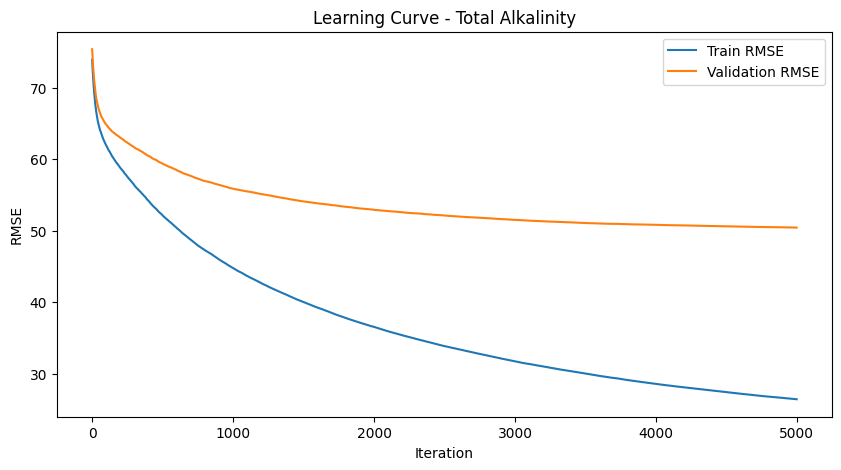

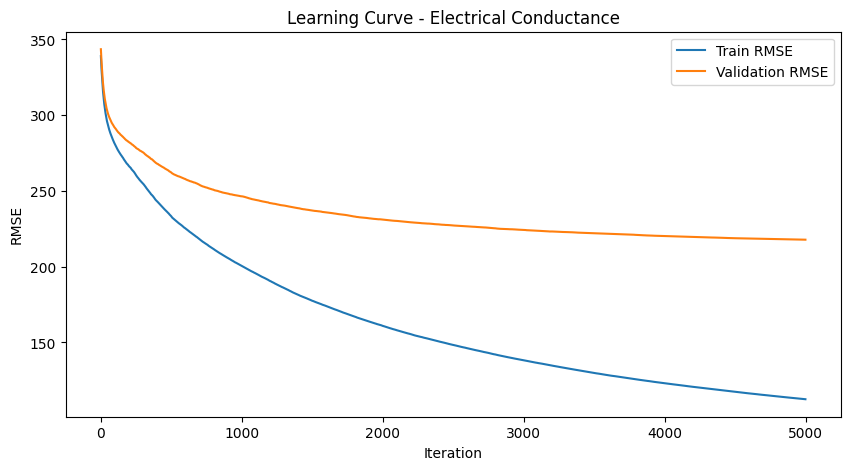

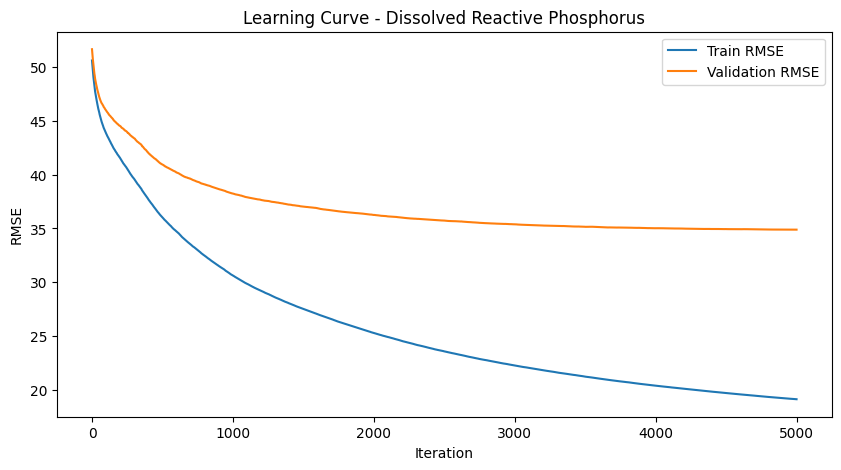

In [26]:
import matplotlib.pyplot as plt

for tgt in targets:
    model = models[tgt]
    evals = model.get_evals_result()

    # CatBoost keys depend on version; these are typical:
    # evals['learn']['RMSE'] and evals['validation']['RMSE']
    learn_key = "learn"
    valid_key = "validation"

    if learn_key not in evals or valid_key not in evals:
        print(f"Could not find expected eval keys for {tgt}. Available keys:", evals.keys())
        continue

    rmse_train = evals[learn_key]["RMSE"]
    rmse_valid = evals[valid_key]["RMSE"]

    plt.figure(figsize=(10, 5))
    plt.plot(rmse_train, label="Train RMSE")
    plt.plot(rmse_valid, label="Validation RMSE")
    plt.title(f"Learning Curve - {tgt}")
    plt.xlabel("Iteration")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

# (6) Fill submission_template.csv

- What this does:
- Loads submission_template.csv
- Fills target columns using your validation predictions
- Saves submission_catboost.csv

In [28]:
SUBMISSION_TEMPLATE_PATH = BASE_DIR + "submission_template.csv"

sub = pd.read_csv(SUBMISSION_TEMPLATE_PATH)
print("Template shape:", sub.shape)
print("Template columns:", sub.columns.tolist())


for tgt in targets:
    if tgt in sub.columns:
        sub[tgt] = val_pred_df[tgt].values
    else:
        print(f"Template does NOT have column '{tgt}'. You may need a rename mapping.")

# col_map = {
#     "Total_Alkalinity": "Total Alkalinity",
#     "Electrical_Conductance": "Electrical Conductance",
#     "Dissolved_Reactive_Phosphorus": "Dissolved Reactive Phosphorus"
# }
# for template_col, pred_col in col_map.items():
#     sub[template_col] = val_pred_df[pred_col].values

OUT_PATH = BASE_DIR + "submission.csv"

pred_cols = ["Total Alkalinity", "Electrical Conductance", "Dissolved Reactive Phosphorus"]
sub[pred_cols] = sub[pred_cols].round(2)

sub.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)
display(sub.head())

Template shape: (200, 6)
Template columns: ['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']
Saved: ./submission.csv


,Latitude,Longitude,Sample Date,Total Alkalinity,Electrical Conductance,Dissolved Reactive Phosphorus
0,-32.043333,27.822778,01-09-2014,98.30,305.25,31.39
1,-33.329167,26.077500,16-09-2015,118.20,435.52,46.43
2,-32.991639,27.640028,07-05-2015,56.87,382.45,25.00
3,-34.096389,24.439167,07-02-2012,51.89,162.48,13.93
4,-32.000556,28.581667,01-10-2014,84.42,132.29,-7.41
